# EME with MEOW

Some components are more efficiently modeled with Eigenmode Expansion.

Gdsfactory provides a plugin for MEOW to efficiently extract component S-parameters through EME.

Currently the component needs to specifically have a single "o1" port facing west, and a single "o2" port facing east, like this taper:

In [1]:
import matplotlib.pyplot as plt
from gdsfactory.simulation.eme import MEOW
import numpy as np
import gdsfactory as gf
from gdsfactory.generic_tech import get_generic_pdk

gf.config.rich_output()
PDK = get_generic_pdk()
PDK.activate()

c = gf.components.taper_cross_section_sine()
c

2023-02-20 17:52:49.057 | INFO     | gdsfactory.config:<module>:50 - Load '/home/runner/work/gdsfactory/gdsfactory/gdsfactory' 6.43.1


[17:52:50] INFO     Using client version: 1.8.4                                                     ]8;id=864510;file:///usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/tidy3d/__init__.py\__init__.py]8;;\:]8;id=130770;file:///usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/tidy3d/__init__.py#120\120]8;;\

AppLayout(children=(Tab(children=(VBox(children=(HBox(children=(Button(layout=Layout(border_bottom='solid 2px …

taper_cross_section_npoints101: uid 79d65662, ports ['o1', 'o2'], references ['extrude_1'], 0 polygons


You also need to explicitly provide a LayerStack to define cross-sections, for instance the generic one:

In [2]:
layerstack = gf.generic_tech.LAYER_STACK

filtered_layerstack = gf.technology.LayerStack(
    layers={
        k: layerstack.layers[k]
        for k in (
            "slab90",
            "core",
            "box",
            "clad",
        )
    }
)

Since you need to make sure that your entire LayerStack has e.g. material information for all present layers, it is safer to only keep the layers that you need for your simulation:

The EME simulator can be instantiated with only these two elements, alongside parameters:

In [3]:
eme = MEOW(component=c, layerstack=filtered_layerstack, wavelength=1.55)

Plotting functions allow you to check your simulation:

In [4]:
eme.plot_structure()

trimesh: threejs viewer

The cross-section themselves:

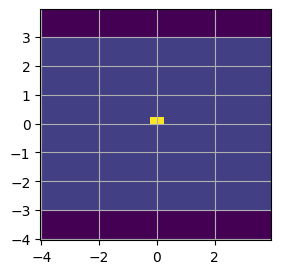

In [5]:
eme.plot_cross_section(xs_num=0)

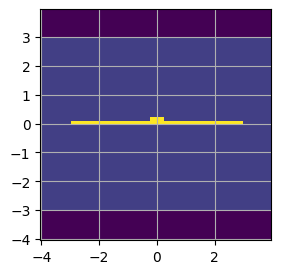

In [6]:
eme.plot_cross_section(xs_num=-1)

And the modes (after calculating them):

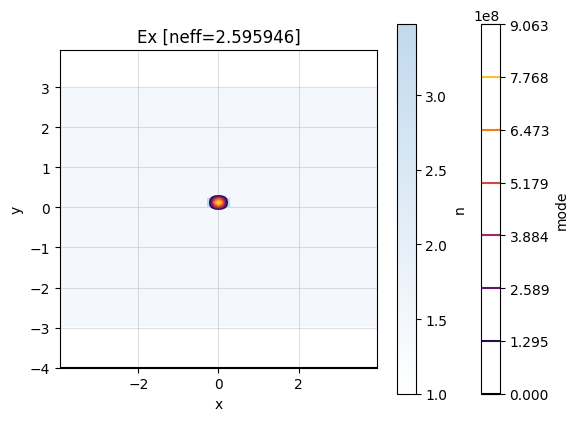

In [7]:
eme.plot_mode(xs_num=0, mode_num=0)

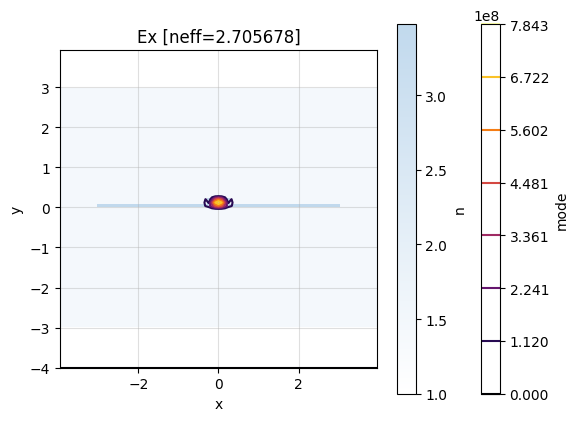

In [8]:
eme.plot_mode(xs_num=-1, mode_num=0)

The S-parameters can be calculated, and are returned in the same format as for the FDTD solvers (the original MEOW S-parameter results S and port_names are saved as attributes):

In [9]:
sp = eme.compute_sparameters()

In [10]:
print(np.abs(sp["o1@0,o2@0"]) ** 2)

1.0


In [11]:
print(eme.port_map)
eme.plot_Sparams()

None


As you can see most light stays on the fundamental TE mode

## Sweep EME length

Lets sweep the length of the taper.

In [12]:
layerstack = gf.generic_tech.LAYER_STACK

filtered_layerstack = gf.technology.LayerStack(
    layers={
        k: layerstack.layers[k]
        for k in (
            "slab90",
            "core",
            "box",
            "clad",
        )
    }
)

c = gf.components.taper(width2=2)
c

AppLayout(children=(Tab(children=(VBox(children=(HBox(children=(Button(layout=Layout(border_bottom='solid 2px …

taper_width22: uid 30864283, ports ['o1', 'o2'], references [], 1 polygons


Lets do a convergence tests on the `cell_length` parameter. This depends a lot on the structure.

```python

import matplotlib.pyplot as plt

trans = []
cells_lengths = [0.1, 0.25, 0.5, 0.75, 1]

for cell_length in cells_lengths:
    m = MEOW(component=c, 
                layerstack=filtered_layerstack, 
                wavelength=1.55,
                resolution_x=100,
                resolution_y=100,
                spacing_x=1,
                spacing_y=-3,
                num_modes=4,
                cell_length=cell_length,
                )
    sp = m.compute_sparameters()
    te0_trans = np.abs(sp["o1@0,o2@0"])**2
    trans.append(te0_trans)
    
plt.plot(cells_lengths, trans, '.-')
plt.title("10um taper, resx = resy = 100, num_modes = 4")
plt.xlabel("Cell length (um)")
plt.ylabel("TE0 transmission")

```

![](https://i.imgur.com/70dU6fo.png)

In [13]:
eme = MEOW(component=c, layerstack=filtered_layerstack, wavelength=1.55)

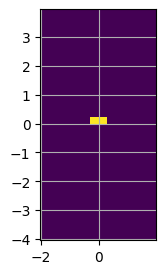

In [14]:
eme.plot_cross_section(xs_num=0)

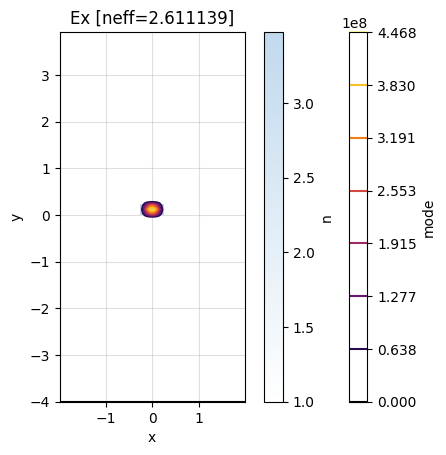

In [15]:
eme.plot_mode(xs_num=0, mode_num=0)

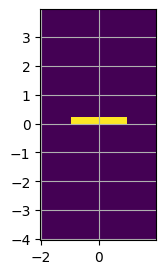

In [16]:
eme.plot_cross_section(xs_num=-1)

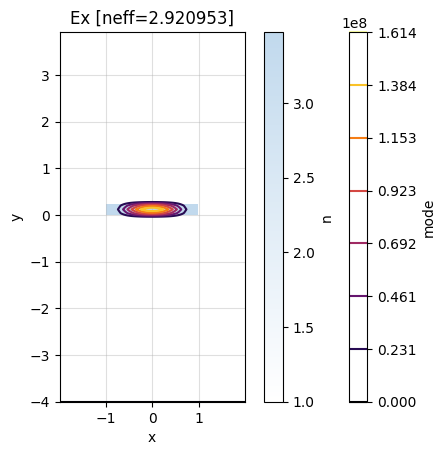

In [17]:
eme.plot_mode(xs_num=-1, mode_num=0)

In [18]:
sp = eme.compute_sparameters()

In [19]:
print(eme.port_map)
eme.plot_Sparams()

None


In [20]:
T = np.abs(sp["o1@0,o2@0"]) ** 2
T

0.9649725107338192

In [21]:
np.abs(sp["o1@0,o2@2"]) ** 2

0.0008810367802534191

In [22]:
lengths = np.array([1, 5, 10])
T = np.zeros_like(lengths, dtype=float)

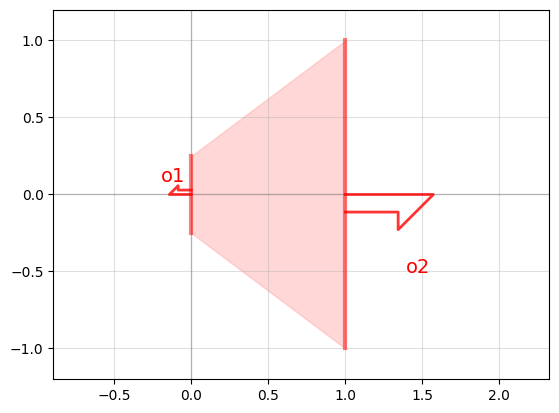

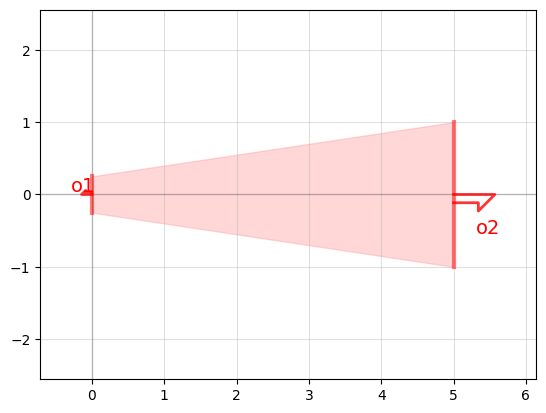

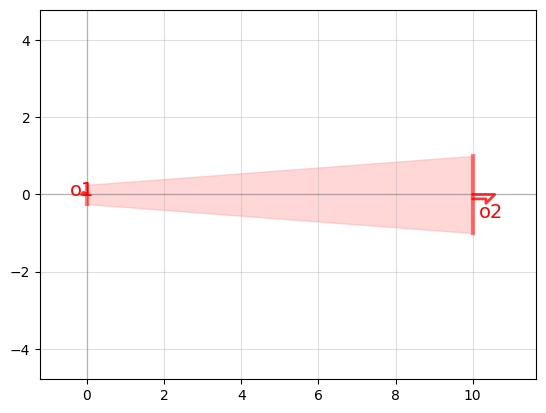

In [23]:
for length in lengths:
    c = gf.components.taper(width2=2, length=length)
    c.plot()

In [24]:
for i, length in enumerate(lengths):
    c = gf.components.taper(width2=10, length=length)
    eme = MEOW(component=c, layerstack=filtered_layerstack, wavelength=1.55)
    sp = eme.compute_sparameters()
    T[i] = np.abs(sp["o1@0,o2@0"]) ** 2

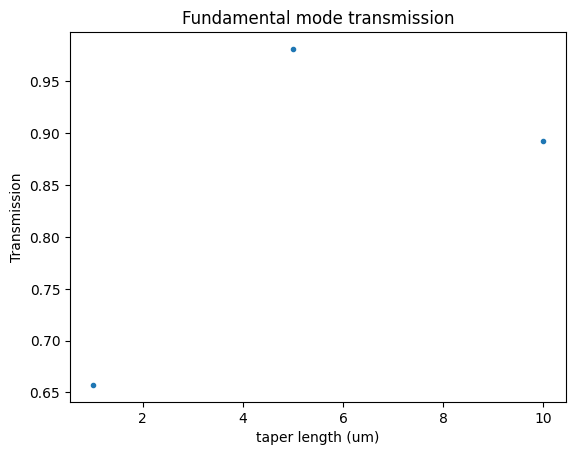

In [25]:
plt.plot(lengths, T, ".")
plt.title("Fundamental mode transmission")
plt.ylabel("Transmission")
plt.xlabel("taper length (um)")

In [26]:
T

array([0.65730639, 0.9813703 , 0.89301136])